# Table of Contents
 <p><div class="lev1"><a href="#Data-Import-and-Preprocessing"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Import and Preprocessing</a></div><div class="lev1"><a href="#Covariance-induced-by-normal-prior-on-$\beta$"><span class="toc-item-num">2&nbsp;&nbsp;</span>Covariance induced by normal prior on <span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-2-Frame" tabindex="0" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B2;</mi></math>" role="presentation" style="position: relative;"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-4" role="math" style="width: 0.643em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.514em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.572em 1000.51em 2.63em -999.998em); top: -2.338em; left: 0.002em;"><span class="mrow" id="MathJax-Span-5"><span class="mi" id="MathJax-Span-6" style="font-family: STIXMathJax_Main-italic;">β<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.002em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.341em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.267em; border-left-width: 0px; border-left-style: solid; width: 0px; height: 1.156em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>β</mi></math></span></span><script type="math/tex" id="MathJax-Element-2">\beta</script></a></div>

In [1]:
IJulia.set_verbose(true)

true

In [2]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in symbol(::String, ::Vararg{String,N}) at ./deprecated.jl:30
 in @glue(::Any) at /Users/imolk/.julia/v0.5/GaussianProcesses/src/GaussianProcesses.jl:22
 in include_from_node1(::String) at ./loading.jl:426
 in eval(::Module, ::Any) at ./boot.jl:234
 in require(::Symbol) at ./loading.jl:357
 in include_string(::String, ::String) at ./loading.jl:380
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:164
 in eventloop(::ZMQ.Socket) at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:138
 in (::IJulia.##25#31)() at ./task.jl:309
while loading /Users/imolk/.julia/v0.5/GaussianProcesses/src/GaussianProcesses.jl, in expression starting on line 29

Use "Dict(a=>b for (a,b) in c)" instead.


# Data Import and Preprocessing
Copy-pasted from `Tucson_analysis.ipynb`.

In [3]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar,
    :PersonalProperty, 
    :PartialInterest,
    :HEAT,
    :COOL,
    :QUALITY,
    :CLASS,
    :WALLS,
    :ROOF,
    :GARAGE,
    ])
believable = zeros(Bool, size(Tucson_sales,1))
for i in 1:size(Tucson_sales,1)
    if isna(Tucson_sales[i,:BuyerSellerRelated])
        continue
    end
    if Tucson_sales[i,:BuyerSellerRelated]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PartialInterest])
        continue
    end
    if Tucson_sales[i,:PartialInterest]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PropertyType])
        continue
    end
    if !(Tucson_sales[i,:PropertyType] in ("2-4 Plex", "Condo/Townhouse", "Single Family"))
        continue
    end
    if isna(Tucson_sales[i,:ValidationDescription])
        continue
    end
    if !(Tucson_sales[i,:ValidationDescription] in ("Good Sale", "Buyer/Seller has an Out-Of-State Address"))
        continue
    end
    if isna(Tucson_sales[i,:SQFT])
        continue
    end
    believable[i] = true
end

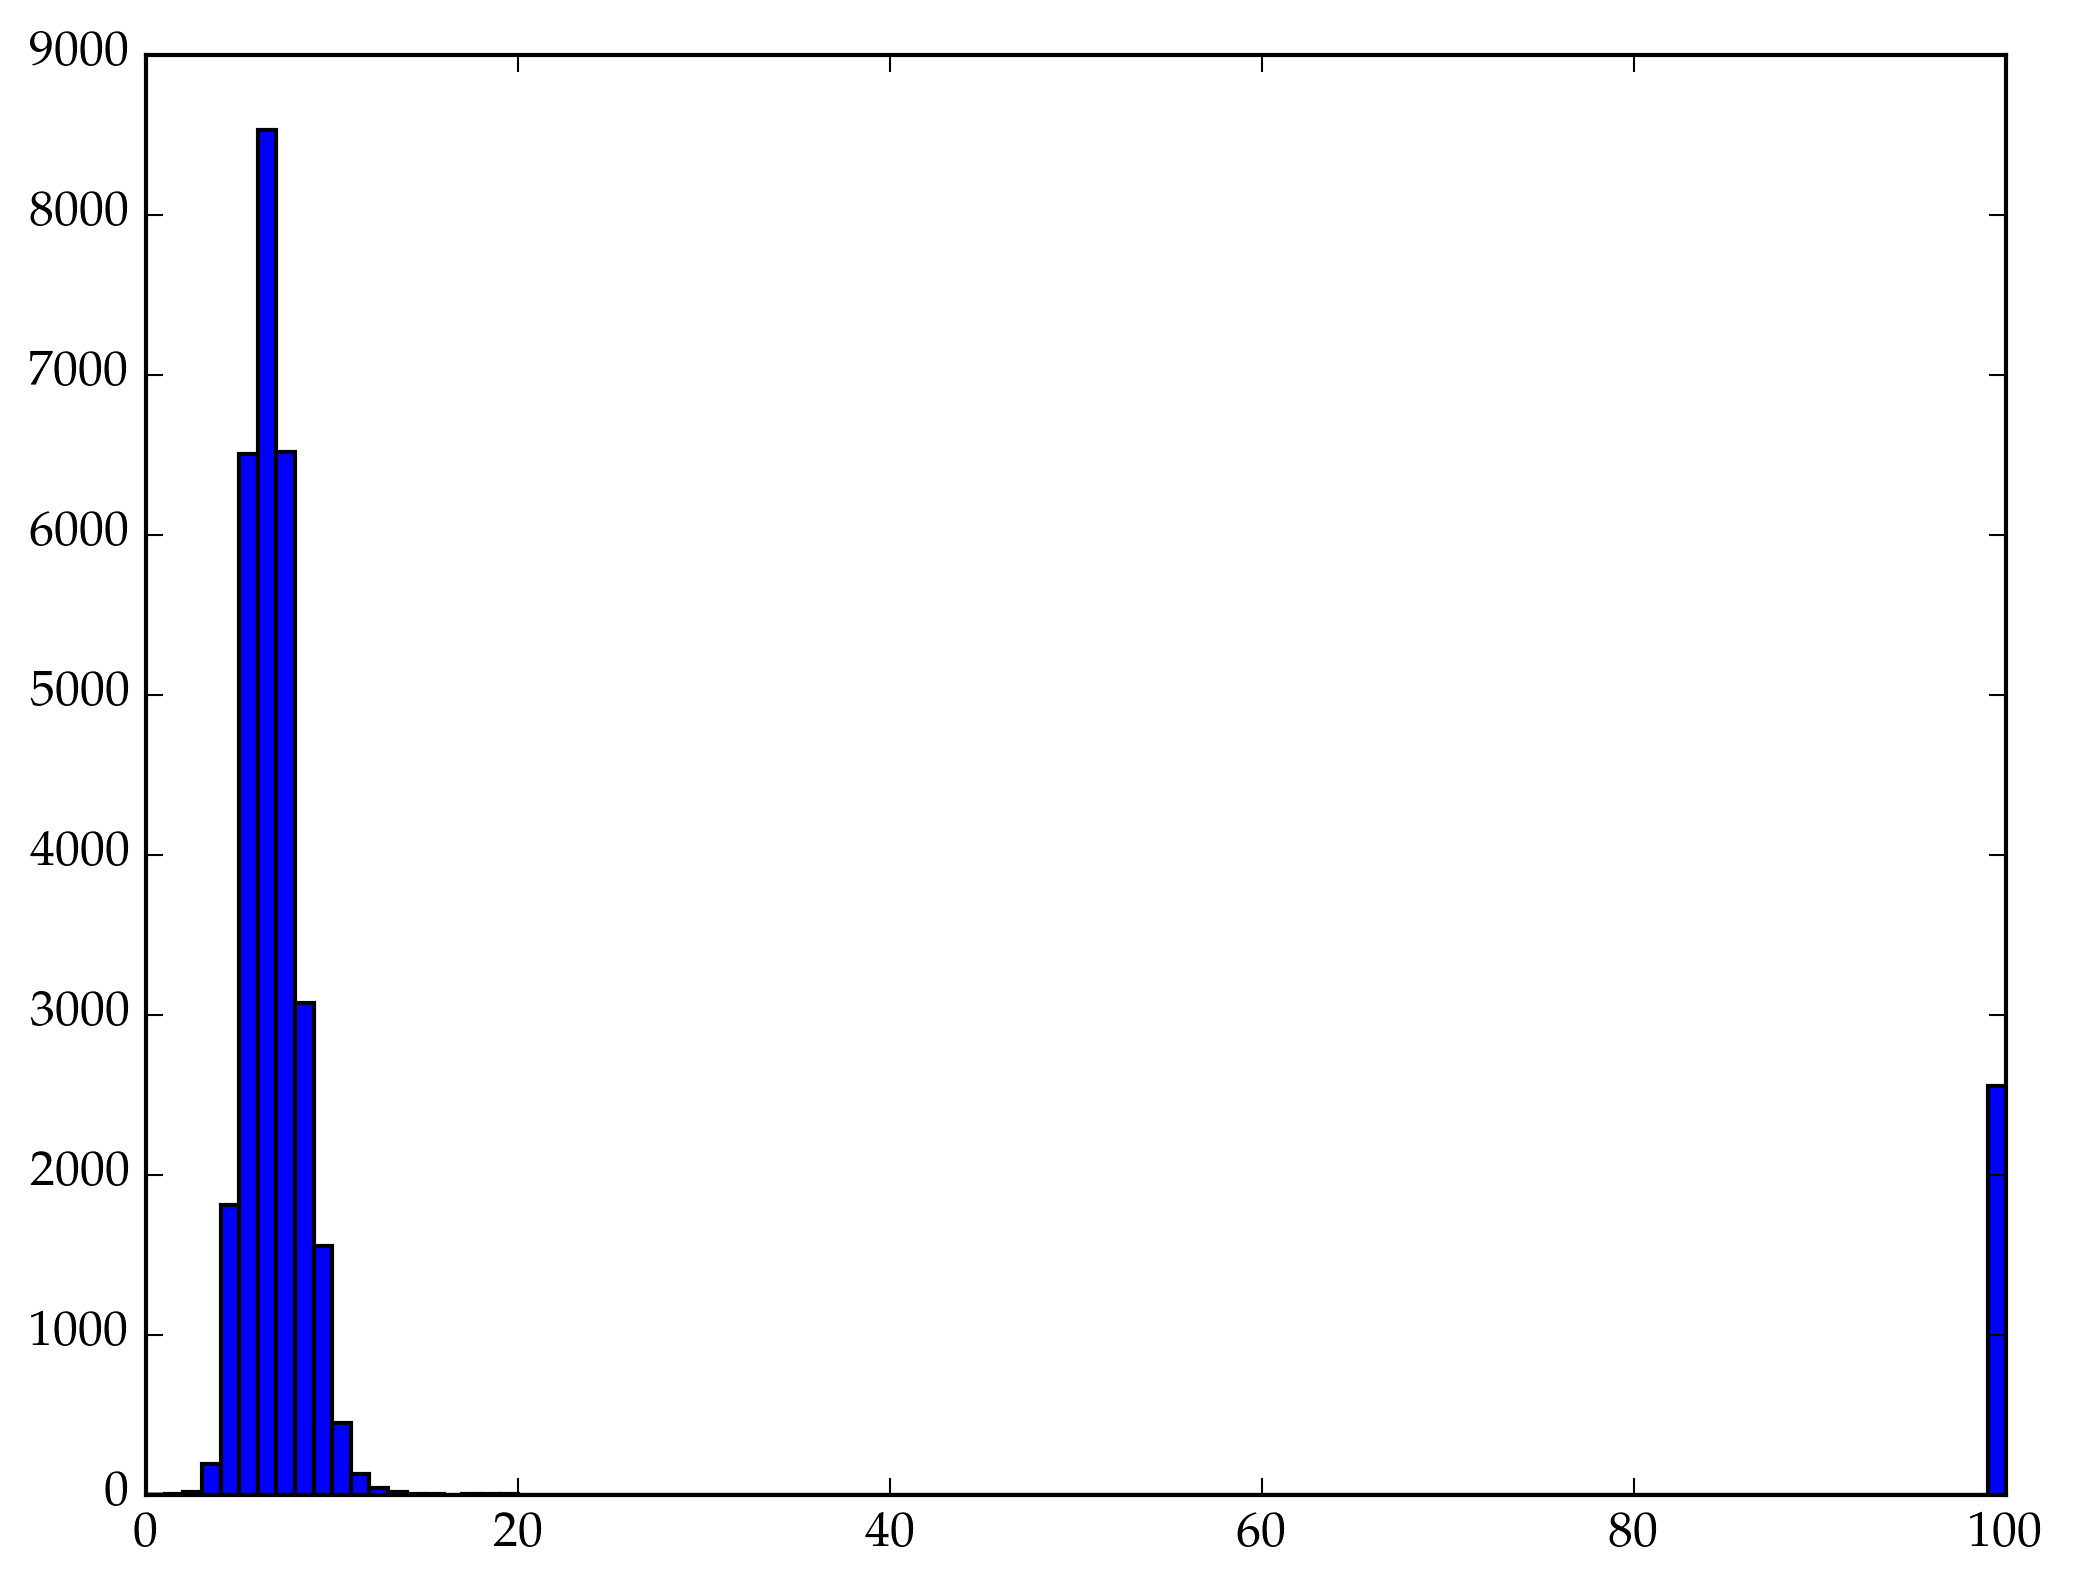

In [4]:
plt.plt[:hist](Tucson_sales[:ROOMS], bins=collect(0:100))
;

In [5]:
recent = Tucson_sales[:,:SaleDate].>"b'201509"
recent_in_believable = Tucson_sales[believable,:SaleDate].>"b'201509"
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
recent_Y_dict=Dict{String, Vector{Float64}}()
recent_X_dict=Dict{String, Array{Float64,2}}()
schdistrs = unique(Tucson_sales[:,:SchDistr])
for name in schdistrs
    Y_dict[name] = log(Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    X_dict[name] =     Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
    recent_Y_dict[name] = log(Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    recent_X_dict[name] =     Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
end
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{String,String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end
sum(recent & believable)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in transpose(::DataFrames.DataFrame) at ./deprecated.jl:771
 in ctranspose(::DataFrames.DataFrame) at ./operators.jl:300
 in macro expansion; at ./In[5]:10 [inlined]
 in anonymous at ./<missing>:?
 in include_string(::String, ::String) at ./loading.jl:380
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:164
 in eventloop(::ZMQ.Socket) at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:138
 in (::IJulia.##25#31)() at ./task.jl:309
while loading In[5], in expression starting on line 8


1569

In [6]:
recent_GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_Y_dict[name]
    if length(Y)==0
        println("no data for ", name)
        continue
    end
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    recent_GP_dict[name] = fit
end
schdistrs_have = collect(keys(recent_GP_dict))
recent_multiGP = GaussianProcesses.GP[recent_GP_dict[name] for name in schdistrs_have]
;

no data for Tanque Verde Unified District


In [7]:
Tucson_sales[:logSalePrice] = log(Tucson_sales[:SalePrice]);

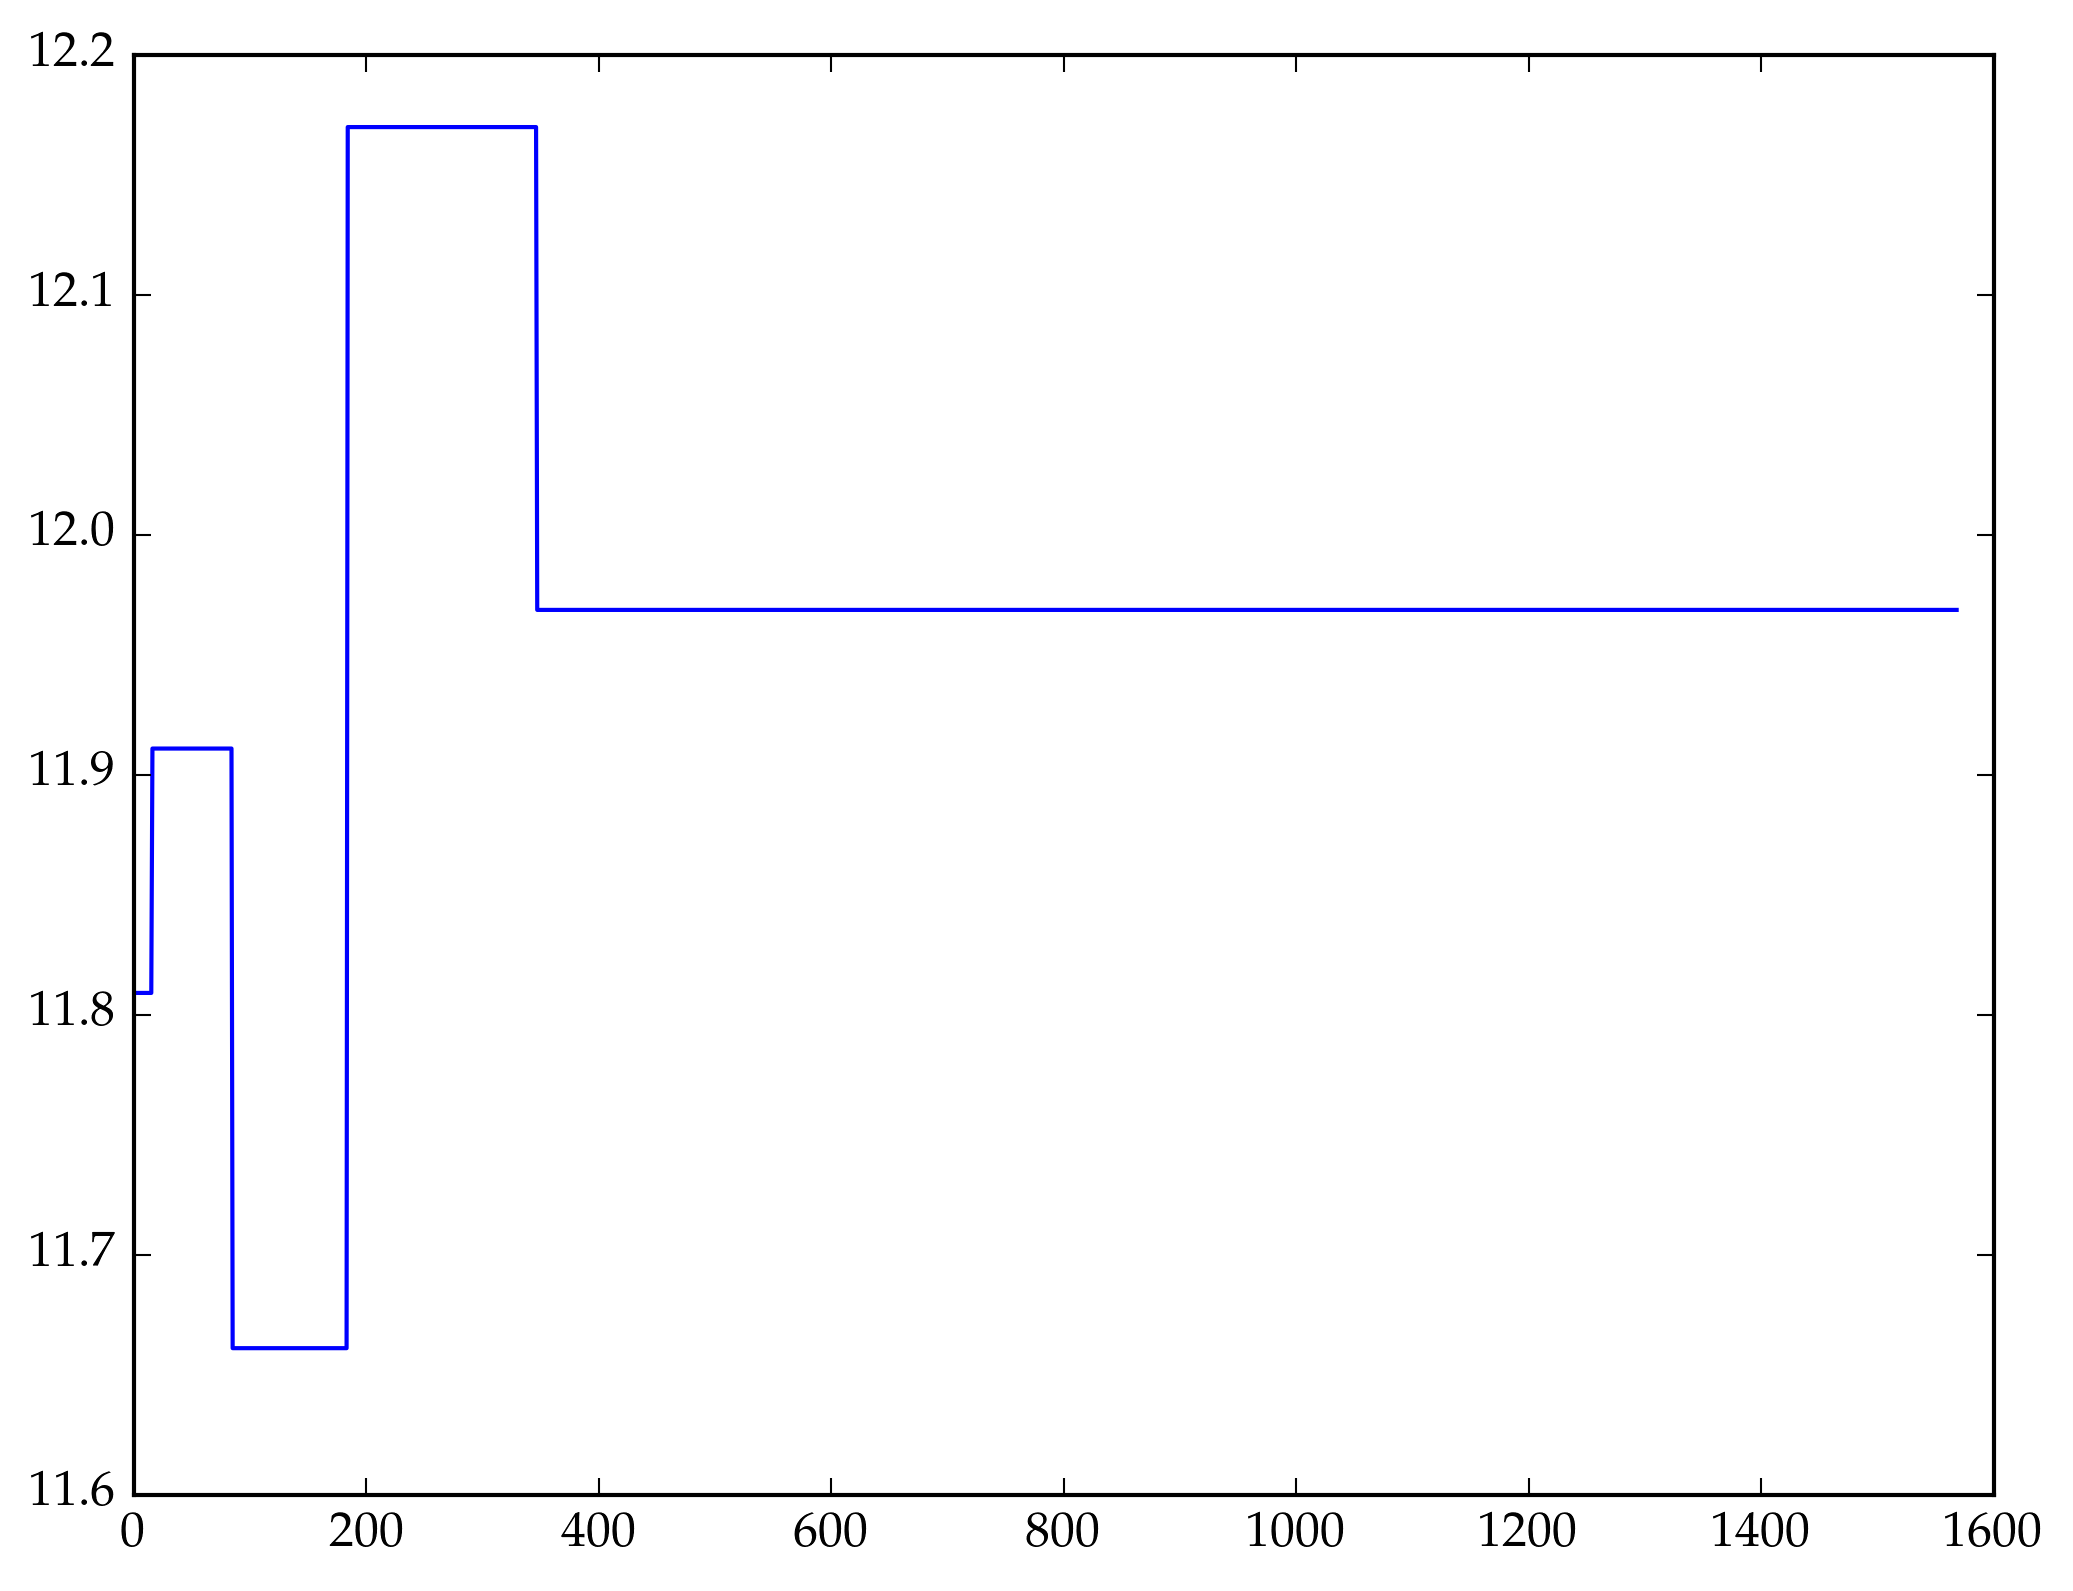

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x329509c10>

In [8]:
nobsv_ = sum([gp.nobsv for gp in recent_multiGP])
m = Array(Float64, nobsv_)
istart = 1
for name in schdistrs_have
    gp = recent_GP_dict[name]
    m[istart:istart+gp.nobsv-1] = mean(gp.m,gp.X)
    istart = istart+gp.nobsv
end
plt.plot(m)

# Covariance induced by normal prior on $\beta$

Here's the idea:
* the linear term $X\beta$, if we put a normal prior on $\beta$ with prior variance $\Sigma_\beta$ induces a covariance term $X \Sigma_\beta X^\intercal$. 
* If we parametrize $\Sigma_\beta$ as a diagonal matrix $I \sigma_\beta^2$ (or perhaps a different value for quantitative and qualitative parameters), we could in theory optimize the marginal likelihood as a function of $(\theta, \sigma_\beta)$, where $\theta$ is the vector of parameters of the spatial covariance kernel.
* That's straightforward enough, but the problem, as always with GPs, is computational. The $X \Sigma_\beta X^\intercal$ creates a dependence between the different regions, so the total likelihood is no longer just the product of the regional likelihoods. This is a big problem since computations scale as $n^3$.

In [9]:
typealias MultiGP Vector{GP}

Array{GaussianProcesses.GP,1}

In [10]:
a = [[1,2] [3,4]]
b = [[1,2,3] [4,5,6] [7,8,9]]
cat([1,2], a,b)

5×5 Array{Int64,2}:
 1  3  0  0  0
 2  4  0  0  0
 0  0  1  4  7
 0  0  2  5  8
 0  0  3  6  9

In [11]:
function cK(mgp::MultiGP)
#     cKdense = zeros(Float64, nobsv, nobsv)
#     istart = 1
#     for name in schdistrs
#         if !haskey(recent_GP_dict, name)
#             continue
#         end
#         gp = recent_GP_dict[name]
#         iend = istart+gp.nobsv-1
#         cKdense[istart:iend,istart:iend] = gp.cK.mat
#         istart = iend+1
#     end
    cKdense=cat([1,2], Array{Float64,2}[gp.cK.mat for gp in mgp]...)
    return cKdense
end
cKdense = cK(recent_multiGP)
;

In [12]:
for_mm = copy(Tucson_sales[believable & recent,:])
for_mm[:SQFT] =  for_mm[:SQFT] .- mean(for_mm[:SQFT])
for_mm[:SQFT] = for_mm[:SQFT] ./ std(for_mm[:SQFT])
for_mm[:ROOMS] = for_mm[:ROOMS] .- mean(for_mm[:ROOMS])
for_mm[:ROOMS] = for_mm[:ROOMS] ./ std(for_mm[:ROOMS])
for_mm[:STORIES] = for_mm[:STORIES] .- mean(for_mm[:STORIES])
for_mm[:STORIES] = for_mm[:STORIES] ./ std(for_mm[:STORIES])
reordering = collect(1:nobsv_)
istart = 1
for name in schdistrs_have
    indices = find(for_mm[:SchDistr] .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
;

In [13]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePrice ~ SQFT + SchDistr + COOL + HEAT + WALLS + QUALITY + STORIES + CLASS + ROOF + GARAGE, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;

In [14]:
mf.terms.terms

10-element Array{Any,1}:
 :SQFT    
 :SchDistr
 :COOL    
 :HEAT    
 :WALLS   
 :QUALITY 
 :STORIES 
 :CLASS   
 :ROOF    
 :GARAGE  

In [15]:
mm.assign[28]

6

In [16]:
print(maximum(D_,1))

[1.0 6.13922 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.8167 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0]

In [17]:
find(maximum(D_,1) .> 1)

2-element Array{Int64,1}:
  2
 29

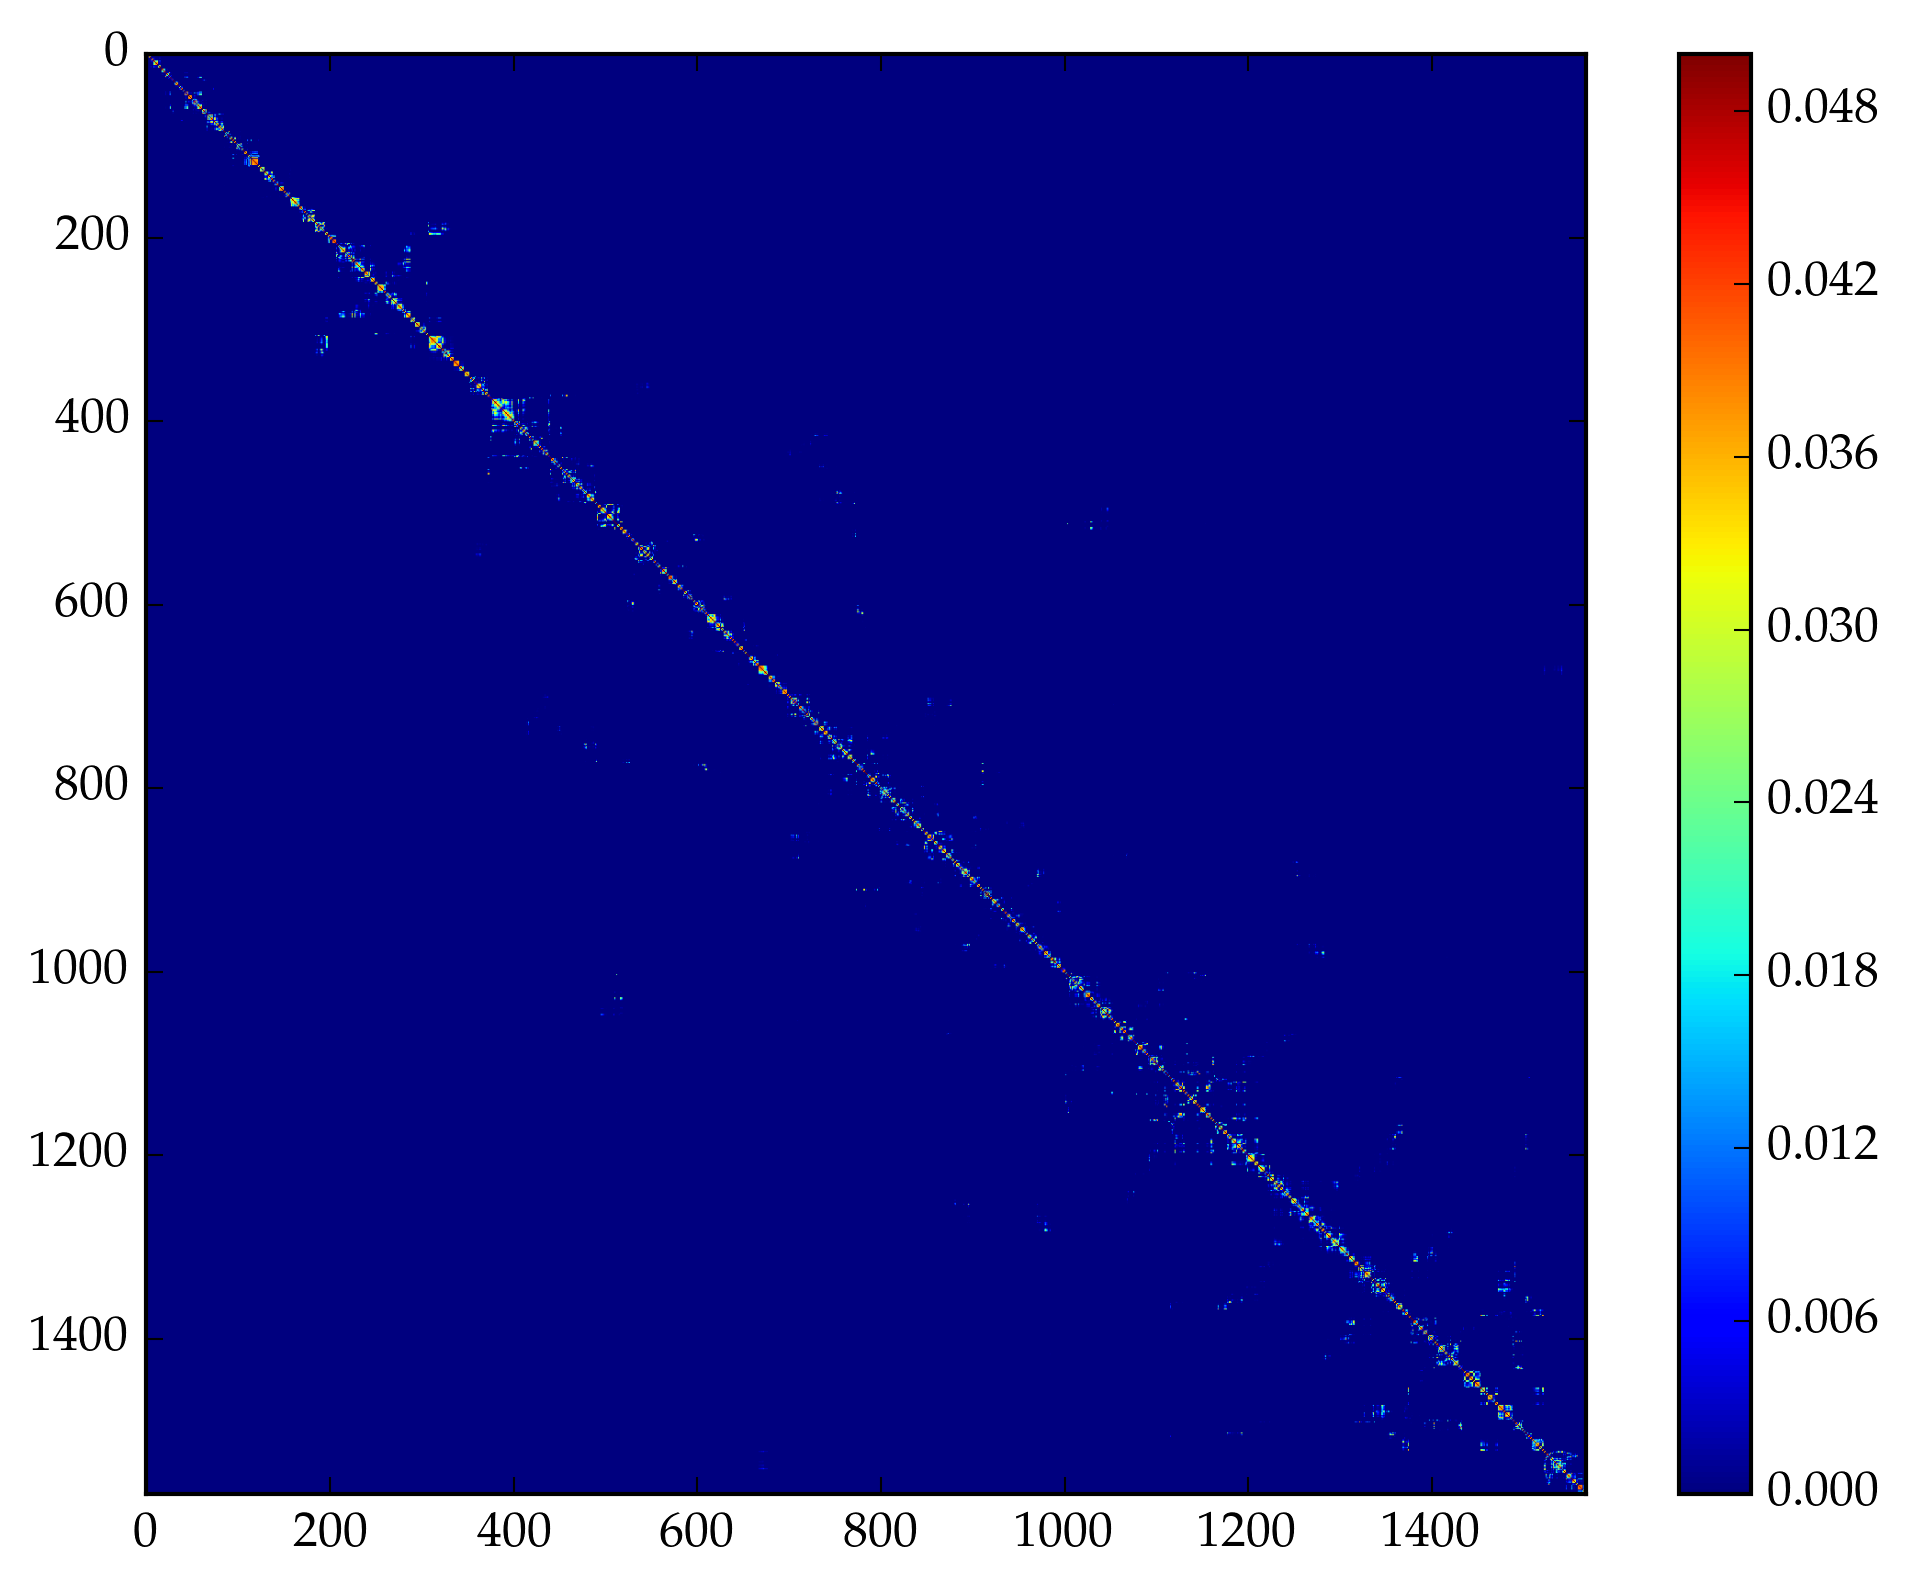

PyObject <matplotlib.colorbar.Colorbar object at 0x32812b310>

In [18]:
plt.imshow(cKdense)
plt.colorbar()

In [19]:
βkern_ = GaussianProcesses.LinIso(log(1.0))

  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:35


Type: GaussianProcesses.LinIso, Params: [0.0]


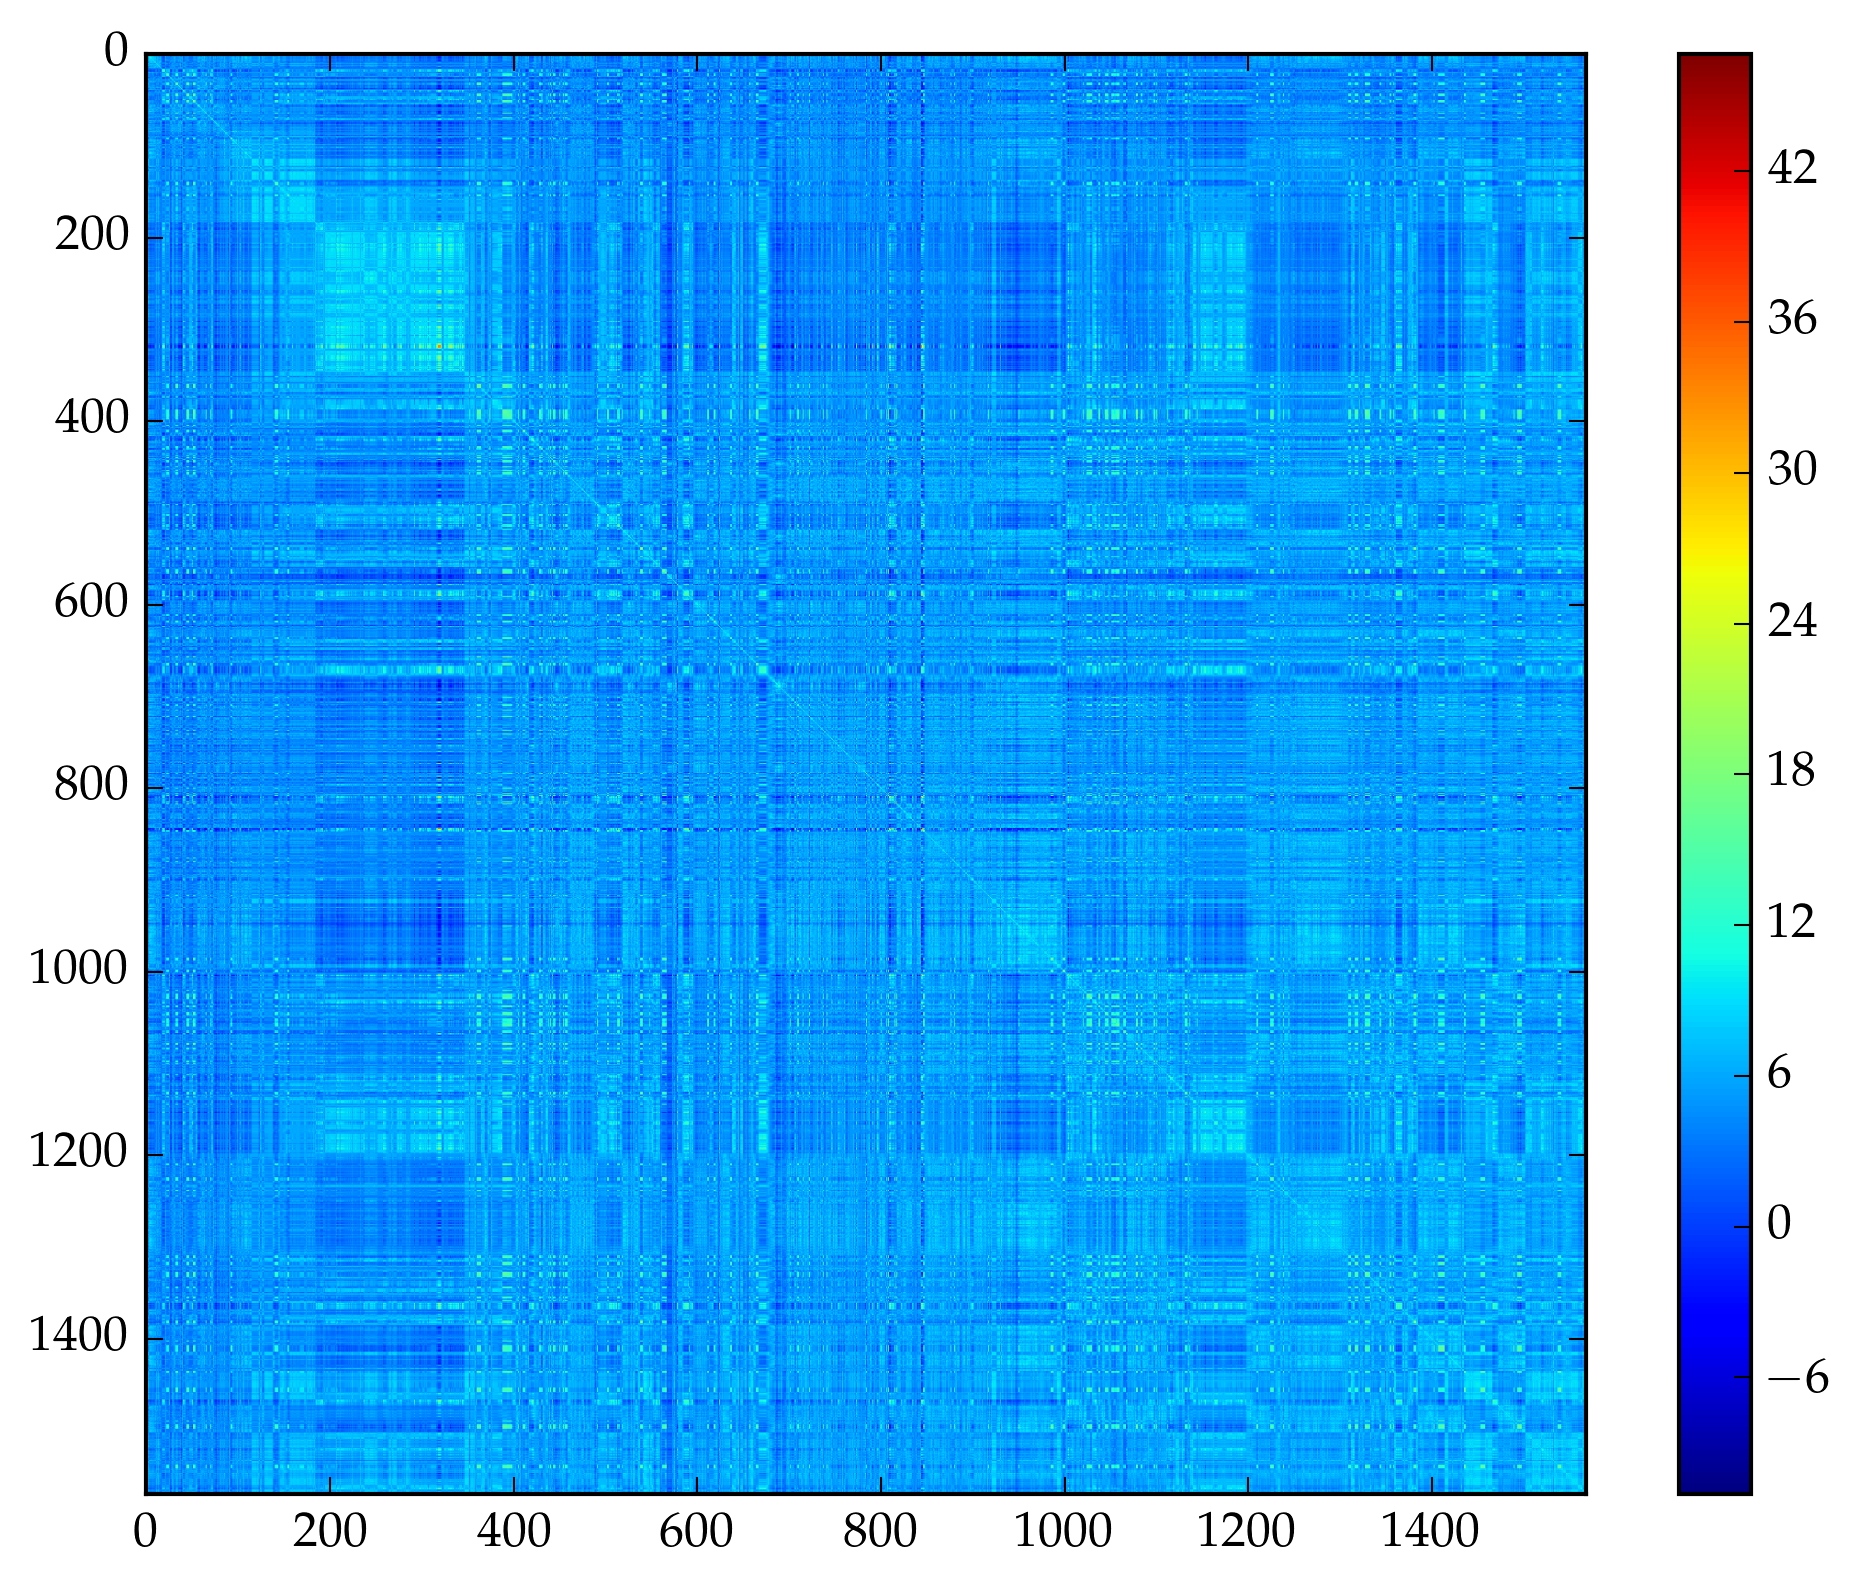

PyObject <matplotlib.colorbar.Colorbar object at 0x3296a3910>

In [20]:
p = size(mm,2)
# σ2_β = ones(Float64,p)
# DΣDt = D * diagm(σ2_β) * D'
DΣDt = cov(βkern_, D_')
plt.imshow(DΣDt)
plt.colorbar()

In [21]:
std(D_,1)

1×46 Array{Float64,2}:
 0.0  1.0  0.205109  0.100499  0.243216  0.41516  0.305212  0.46435  0.466111  0.0666661  0.0252458  0.0712462  0.212057  0.106526  0.170519  0.324856  0.296751  0.245493  0.360681  0.0617406  0.498305  0.0436991  0.301028  0.0356915  0.0356915  0.445208  0.431201  0.153778  1.0  0.0504432  0.172266  0.360067  0.318016  0.0755438  0.0906759  0.443893  0.493083  0.0563792  0.0436991  0.299329  0.39487  0.0906759  0.475456  0.500157  0.0906759  0.355711

We follow in the footsteps of `GaussianProcesses.update_mll!` to compute the marginal log-likelihood:

At this stage we could wrap all this in a function and optimize mLL. But we'll be better off if we also have gradients. Again, we follow in the footsteps of `GaussianProcesses.update_mll_and_dmll!`.

In [22]:
type MultiGPCovars{MT<:GaussianProcesses.Mean, KT1<:GaussianProcesses.Kernel, KT2<:GaussianProcesses.Kernel}
    D::Array{Float64,2}
    y::Vector{Float64}
    mgp::MultiGP
    p::Int
    dim::Int
    nobsv::Int
    logNoise::Float64
    m::MT
    k::KT1
    βkern::KT2
    # Auxiliary data
    cK::PDMats.PDMat        # (k + obsNoise)
    alpha::Vector{Float64}  # (k + obsNoise)⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood
    function MultiGPCovars(D::Array{Float64,2}, 
        y::Vector{Float64},
        mgp::MultiGP, 
        p::Int,
        dim::Int,
        nobsv::Int,
        logNoise::Float64,
        m::MT,
        k::KT1,
        βkern::KT2
        )
        mgpcv = new(D, y, mgp, p, dim, nobsv, logNoise, m, k, βkern)
        update_mll!(mgpcv)
        return mgpcv
    end
end

In [23]:
function MultiGPCovars{KT2<:GaussianProcesses.Kernel}(D::Array{Float64,2}, mgp::MultiGP, βkern::KT2)
    nobsv = sum([gp.nobsv for gp in mgp])
    size(D,1) == nobsv || throw(ArgumentError("incompatible dimensions of covariates matrix and gaussian processes"))
    first_gp = mgp[1]
    dim = first_gp.dim
    logNoise = first_gp.logNoise
    k = first_gp.k
    m = first_gp.m
    # harmonize parameters
    for gp in mgp
        gp.k = k
        gp.m = m
        gp.logNoise = logNoise
    end
    p = size(D,2)
    y = vcat([gp.y for gp in recent_multiGP]...)
    mgpcv = MultiGPCovars{typeof(m),typeof(k),KT2}(D, y, mgp, p, dim, nobsv, logNoise, m, k, βkern)
    return mgpcv
end

function propagate_params!(mgpcv::MultiGPCovars)
    for gp in mgpcv.mgp
        # harmonize parameters
        gp.k = mgpcv.k
        gp.m = mgpcv.m
        gp.logNoise = mgpcv.logNoise
    end
end

function update_mll!(mgpcv::MultiGPCovars)
    propagate_params!(mgpcv)
    for gp in mgpcv.mgp
        # update mLL of component GP (includes some useless computational work)
        GaussianProcesses.update_mll!(gp)
    end
    m = vcat([mean(gp.m,gp.X) for gp in mgpcv.mgp]...)
    DΣDt = cov(mgpcv.βkern, mgpcv.D')
    mgpcv.cK = PDMats.PDMat(cK(mgpcv.mgp) + DΣDt)
    mgpcv.alpha = mgpcv.cK \ (mgpcv.y .- m)
    mgpcv.mLL = -dot((mgpcv.y-m),mgpcv.alpha)/2.0 - logdet(mgpcv.cK)/2.0 - mgpcv.nobsv*log(2π)/2.0
end

update_mll! (generic function with 1 method)

In [24]:
mgpcv=MultiGPCovars(D_, recent_multiGP::MultiGP, βkern_);

In [25]:
function update_mll_and_dmll!(mgpcv::MultiGPCovars; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!(mgpcv)
    n_mean_params = GaussianProcesses.num_params(mgpcv.m)
    n_kern_params = GaussianProcesses.num_params(mgpcv.k)
    n_beta_params = GaussianProcesses.num_params(mgpcv.βkern)
    dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = mgpcv.logNoise
    α = mgpcv.alpha
    i=1
    if noise
        dmLL[i] = exp(2*logNoise)*trace((α*α' - mgpcv.cK \ eye(mgpcv.nobsv)))
        i+=1
    end
    if mean
        Mgrads = vcat([GaussianProcesses.grad_stack(gp.m, gp.X) for gp in recent_multiGP]...)
        for j in 1:n_mean_params
            dmLL[i] = dot(Mgrads[:,j],α)
            i+=1
        end
    end
    if kern
        Kgrads = cat([1,2], [GaussianProcesses.grad_stack(gp.k, gp.X) for gp in recent_multiGP]...)
        for j in 1:n_kern_params
            dmLL[i] = trace((α*α' - mgpcv.cK \ eye(mgpcv.nobsv))*Kgrads[:,:,j])/2
            i+=1
        end
    end
    if beta
        #     Kgrads = -2.0*reshape(DΣDt, size(DΣDt,1), size(DΣDt,2), 1)
        Kgrads = GaussianProcesses.grad_stack(mgpcv.βkern, mgpcv.D')
        for j in 1:1
            dmLL[i] = trace((α*α' - mgpcv.cK \ eye(mgpcv.nobsv))*Kgrads[:,:,j])/2
            i+=1
        end
    end
    mgpcv.dmLL = dmLL
end

update_mll_and_dmll! (generic function with 1 method)

In [26]:
function get_params(mgpcv::MultiGPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, mgpcv.logNoise); end
    if mean;  append!(params, GaussianProcesses.get_params(mgpcv.m)); end
    if kern; append!(params,  GaussianProcesses.get_params(mgpcv.k)); end
    if beta; append!(params,  GaussianProcesses.get_params(mgpcv.βkern)); end
    return params
end

get_params (generic function with 1 method)

In [27]:
function set_params!(mgpcv::MultiGPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        mgpcv.logNoise = hyp[i]
        i+=1
    end
    if mean
        GaussianProcesses.set_params!(mgpcv.m, hyp[i:i+GaussianProcesses.num_params(mgpcv.m)-1])
        i+=GaussianProcesses.num_params(mgpcv.m)
    end
    if kern
        GaussianProcesses.set_params!(mgpcv.k, hyp[i:i+GaussianProcesses.num_params(mgpcv.k)-1])
        i+=GaussianProcesses.num_params(mgpcv.k)
    end
    if beta
        GaussianProcesses.set_params!(mgpcv.βkern, hyp[i:i+GaussianProcesses.num_params(mgpcv.βkern)-1])
        i+=GaussianProcesses.num_params(mgpcv.βkern)
    end
    propagate_params!(mgpcv)
end

set_params! (generic function with 1 method)

In [28]:
@doc """
# Description
A function for optimising the GP hyperparameters based on type II maximum likelihood estimation. This function performs gradient based optimisation using the Optim pacakge to which the user is referred to for further details.

# Arguments:
* `gp::GP`: Predefined Gaussian process type
* `noise::Bool`: Noise hyperparameters should be optmized
* `mean::Bool`: Mean function hyperparameters should be optmized
* `kern::Bool`: Kernel function hyperparameters should be optmized
* `kwargs`: Keyword arguments for the optimize function from the Optim package
""" ->
function GaussianProcesses.optimize!(mgpcv::MultiGPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true, 
                    method=ConjugateGradient(), kwargs...)
    function mll(hyp::Vector{Float64})
        set_params!(mgpcv, hyp; noise=noise, mean=mean, kern=kern, beta=true)
        update_mll!(mgpcv)
        return -mgpcv.mLL
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        set_params!(mgpcv, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
        update_mll_and_dmll!(mgpcv; noise=noise, mean=mean, kern=kern, beta=beta)
        grad[:] = -mgpcv.dmLL
    end
    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        set_params!(mgpcv, hyp; noise=noise, mean=mean, kern=kern)
        update_mll_and_dmll!(mgpcv; noise=noise, mean=mean, kern=kern)
        grad[:] = -mgpcv.dmLL
        return -mgpcv.mLL
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = get_params(mgpcv;  noise=noise, mean=mean, kern=kern, beta=beta)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    print(results)
end

GaussianProcesses.optimize!

In [29]:
update_mll_and_dmll!(mgpcv)
prev_params=get_params(mgpcv)
prev_mLL=mgpcv.mLL
prev_dmLL=mgpcv.dmLL

5-element Array{Float64,1}:
  552.306    
    0.0972022
 -126.327    
  155.201    
   36.8588   

Check that the analytical derivatives match the numerical approximations:

In [30]:
dθ=[1.0, 2.0, 3.0, 4.0, 5.0]*1e-5
set_params!(mgpcv, prev_params.+dθ)
update_mll_and_dmll!(mgpcv)

println("change in log likelihood: ", mgpcv.mLL-prev_mLL)
println("expected change in log likelihood: ", dot(prev_dmLL, dθ))

change in log likelihood: 0.009785076658545222
expected change in log likelihood: 0.009786159734871257


In [31]:
optimize!(mgpcv)

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-2.3025750929940454,11.809070155357194, ...]
 * Minimizer: [-1.789352857804498,12.00029929270018, ...]
 * Minimum: -3.449871e+02
 * Iterations: 85
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 283
 * Gradient Calls: 198

So… this works, but it's incredibly brute force and very slow. The problem is that we haven't taken advantage of the structure of the covariance matrix, which is the sum of a block diagonal matrix (the spatial covariances within each region), and a low-rank contribution from the linear model.

In [32]:
@time update_mll_and_dmll!(mgpcv);

  9.574512 seconds (30.49 M allocations: 4.351 GB, 19.75% gc time)


First, start by using the fact that the Cholesky decomposition of a block diagonal matrix is a block diagonal matrix of the component Cholesky factors.

In [33]:
function cK_PD(mgp::MultiGP)
    factors = cat([1,2], Array{Float64,2}[gp.cK.chol.factors for gp in mgp]...)
    cK_chol = Cholesky(factors, mgp[1].cK.chol.uplo)
    cK_PD = PDMats.PDMat(cK_chol)
    return cK_PD
end

cK_PD (generic function with 1 method)

In [34]:
@time cK1 = cK_PD(mgpcv.mgp);

  0.177376 seconds (140.03 k allocations: 43.364 MB, 4.87% gc time)


In [35]:
@time cK2 = PDMats.PDMat(cK(mgpcv.mgp));

  0.039804 seconds (179 allocations: 37.570 MB, 8.01% gc time)


Strangely that's actually slower now. Check that they are the same:

In [36]:
maximum(cK1.mat.-cK2.mat)

5.551115123125783e-17

In [37]:
?LinAlg.lowrankupdate!

```
lowrankupdate!(C::Cholesky, v::StridedVector) -> CC::Cholesky
```

Update a Cholesky factorization `C` with the vector `v`. If `A = C[:U]'C[:U]` then `CC = cholfact(C[:U]'C[:U] + v*v')` but the computation of `CC` only uses `O(n^2)` operations. The input factorization `C` is updated in place such that on exit `C == CC`. The vector `v` is destroyed during the computation.


In [38]:
function update_mll!(mgpcv::MultiGPCovars)
    propagate_params!(mgpcv)
    for gp in mgpcv.mgp
        # update mLL of component GP (includes some useless computational work)
        GaussianProcesses.update_mll!(gp)
    end
    m = vcat([mean(gp.m,gp.X) for gp in mgpcv.mgp]...)
#     DΣDt = cov(mgpcv.βkern, mgpcv.D')
    cK_chol = cK_PD(mgpcv.mgp).chol
    ell = exp(mgpcv.βkern.ll)
    for i in 1:mgpcv.p
        LinAlg.lowrankupdate!(cK_chol, mgpcv.D[:,i]./ell)
    end
    mgpcv.cK = PDMats.PDMat(cK_chol)
    
#     cK_slow = PDMats.PDMat(cK(mgpcv.mgp) + DΣDt)
#     println("difference: ", maximum(mgpcv.cK.mat - cK_slow.mat))
    
    mgpcv.alpha = mgpcv.cK \ (mgpcv.y .- m)
    mgpcv.mLL = -dot((mgpcv.y-m),mgpcv.alpha)/2.0 - logdet(mgpcv.cK)/2.0 - mgpcv.nobsv*log(2π)/2.0
end
function update_mll_and_dmll!(mgpcv::MultiGPCovars; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!(mgpcv)
    n_mean_params = GaussianProcesses.num_params(mgpcv.m)
    n_kern_params = GaussianProcesses.num_params(mgpcv.k)
    n_beta_params = GaussianProcesses.num_params(mgpcv.βkern)
    dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = mgpcv.logNoise
    α = mgpcv.alpha
    i=1
    if noise
        dmLL[i] = exp(2*logNoise)*trace((α*α' - mgpcv.cK \ eye(mgpcv.nobsv)))
        i+=1
    end
    if mean
        Mgrads = vcat([GaussianProcesses.grad_stack(gp.m, gp.X) for gp in recent_multiGP]...)
        for j in 1:n_mean_params
            dmLL[i] = dot(Mgrads[:,j],α)
            i+=1
        end
    end
    if kern
        Kgrads = cat([1,2], [GaussianProcesses.grad_stack(gp.k, gp.X) for gp in recent_multiGP]...)
        for j in 1:n_kern_params
            dmLL[i] = trace((α*α' - mgpcv.cK \ eye(mgpcv.nobsv))*Kgrads[:,:,j])/2
            i+=1
        end
    end
    if beta
        #     Kgrads = -2.0*reshape(DΣDt, size(DΣDt,1), size(DΣDt,2), 1)
        Kgrads = GaussianProcesses.grad_stack(mgpcv.βkern, mgpcv.D')
        for j in 1:1
            dmLL[i] = trace((α*α' - mgpcv.cK \ eye(mgpcv.nobsv))*Kgrads[:,:,j])/2
            i+=1
        end
    end
    mgpcv.dmLL = dmLL
end

update_mll_and_dmll! (generic function with 1 method)

In [39]:
Profile.clear()
@profile for _ in 1:10;update_mll!(mgpcv); end

In [40]:
using ProfileView

In [41]:
Profile.print()

7190 ./task.jl:309; (::IJulia.##25#31)()
 7190 .../IJulia/src/IJulia.jl:138; eventloop(::ZMQ.Socket)
  7189 ...rc/execute_request.jl:164; execute_request(::ZMQ.Socket, ::...
   7189 ./loading.jl:380; include_string(::String, ::String)
    7189 ./<missing>:?; anonymous
     7189 ./profile.jl:16; macro expansion;
      7189 ./In[39]:2; macro expansion;
       2268 ./In[38]:5; update_mll!(::MultiGPCovars{...
        166  ...Processes/src/GP.jl:85; update_mll!(::GaussianProcess...
         163 ...rnels/stationary.jl:29; cov(::GaussianProcesses.SEIso...
          152 .../kernels/se_iso.jl:26; cov
         3   ...rnels/stationary.jl:30; cov(::GaussianProcesses.SEIso...
        2100 ...Processes/src/GP.jl:86; update_mll!(::GaussianProcess...
         641  ./array.jl:176; eye(::Type{T}, ::Int64, ::I...
          27  ./array.jl:159; fill!(::Array{Float64,2}, :...
          610 ./boot.jl:321; Array{Float64,N}(::Int64, :...
         4    ./array.jl:178; eye(::Type{T}, ::Int64, ::I...
         44 

In [44]:
update_mll_and_dmll!(mgpcv); # warmu up
@time update_mll_and_dmll!(mgpcv);

  7.811069 seconds (23.91 M allocations: 3.244 GB, 20.58% gc time)
